By [Martin Millon](https://martin-millon.gitlab.io) on August 2023.

This notebook details how to reconstruct the JWST Point Spread Function (PSF) using stars in the field of view. We will use F200W observation already drizzled to 40mas/pixel. Ideally, this notebook could be run before the drizzling, but we will reconstruct the effective PSF, after drizzling. 

__Warning__ : Estimating the noise properly is crucial. Noise maps should be given in the same units than the data and must include a proper estimation of the Poisson noise.

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from astropy.io import fits
import pyregion

from starred.psf.psf import PSF
from starred.psf.loss import Loss
from starred.optim.optimization import Optimizer
from starred.psf.parameters import ParametersPSF
from starred.plots import plot_function as pltf
from starred.utils.noise_utils import propagate_noise


import jax
jax.config.update("jax_enable_x64", True) #we require double digit precision, this can be removed on GPU

### Setup model parameters

In [2]:
# Parameters
subsampling_factor = 2
gain = 1. # noise maps are already given in the correct units

lambda_scales = 3.
lambda_hf = 3.
lambda_positivity = 1000. #penalising term if the full psf have negative pixels
include_moffat = True
regularize_full_psf = False #If True, regularise [m(x)+b(x)]. Regularise only the b(x) if False.
elliptical = False # if you want to fit ellitpical moffat or simply circular 

use_masks = True
MC_realisation = 5000 #Use 5000 to reproduce exactly Fig. 11 of Millon et al. 2024. 500 is largely sufficient otherwise. 

band = 'f200w'
optim_method = 'Newton-CG'
data_path = os.path.join('data', '7_data', band)
simname = 'reconstruction_subsampling'
outpath = os.path.join('output', '7_output_JWST_PSF', simname + '_%i'%subsampling_factor)
os.makedirs(outpath, exist_ok=True)

# noise_map_path = '../data/1_obs_noise_maps'
convolution_method = 'scipy' #choose 'fft' for a faster implementation on CPU if your version of jax is < 0.4.9, 'scipy' is the fastest on the most recent version of jax


### Retrieve and renormalise the data.

In [3]:
# Data 
file_paths = sorted(glob.glob(os.path.join(data_path, 'star*.fits')))
data = np.array([fits.open(f)[0].data for f in file_paths]) * gain 
N = len(file_paths) # number of stars

image_size = np.shape(data)[1] # data dimensions
image_size_up = image_size * subsampling_factor 

# Noise map generated from the JWST exposure maps:
file_paths = sorted(glob.glob(os.path.join(data_path, 'iweight_maps*.fits')))
sigma_2 = np.array([fits.open(f)[0].data for f in file_paths])

#Renormalise your data and the noise maps by the max of the first image. Works better when using adabelief
norm = data[0].max() / 100.
data /= norm
sigma_2 /= norm**2


### Add masks (optional)
Masks can be generated with the 'region' function of DS9 and then save as *.reg files

In [4]:
#Masks 
masks = np.ones((N, image_size, image_size))
if use_masks: 
    for i in range(N):
        possiblemaskfilepath = os.path.join(data_path, 'mask_%s.reg'%str(i))
        if os.path.exists(possiblemaskfilepath):
            print('Using mask %s for star %i !'%(possiblemaskfilepath, i+1))
            r = pyregion.open(possiblemaskfilepath)
            masks[i, :, :] =  1 - r.get_mask(shape=(image_size, image_size)).astype(float)

        #mask central pixel if they are saturated (use with caution!)
        ind = np.where(data[i, : ,: ] <= 0)
        for j in range(len(ind[0][:])):
            x,y = ind[0][j], ind[1][j]
            if image_size/2 - 4 < x < image_size/2 + 4 and image_size/2 - 4 < y < image_size/2 + 4: 
                print(f'Central pixel {x}, {y} saturated for star {i+1}.')
                masks[i, x, y] = 0

        print(f'Masking a total of {image_size**2 - masks[i].sum()} pixels for star {i+1}.')


Using mask data/7_data/f200w/mask_0.reg for star 1 !
Masking a total of 177.0 pixels for star 1.
Using mask data/7_data/f200w/mask_1.reg for star 2 !
Masking a total of 1106.0 pixels for star 2.
Using mask data/7_data/f200w/mask_2.reg for star 3 !
Masking a total of 1057.0 pixels for star 3.
Masking a total of 0.0 pixels for star 4.


## Data and masks visualisation

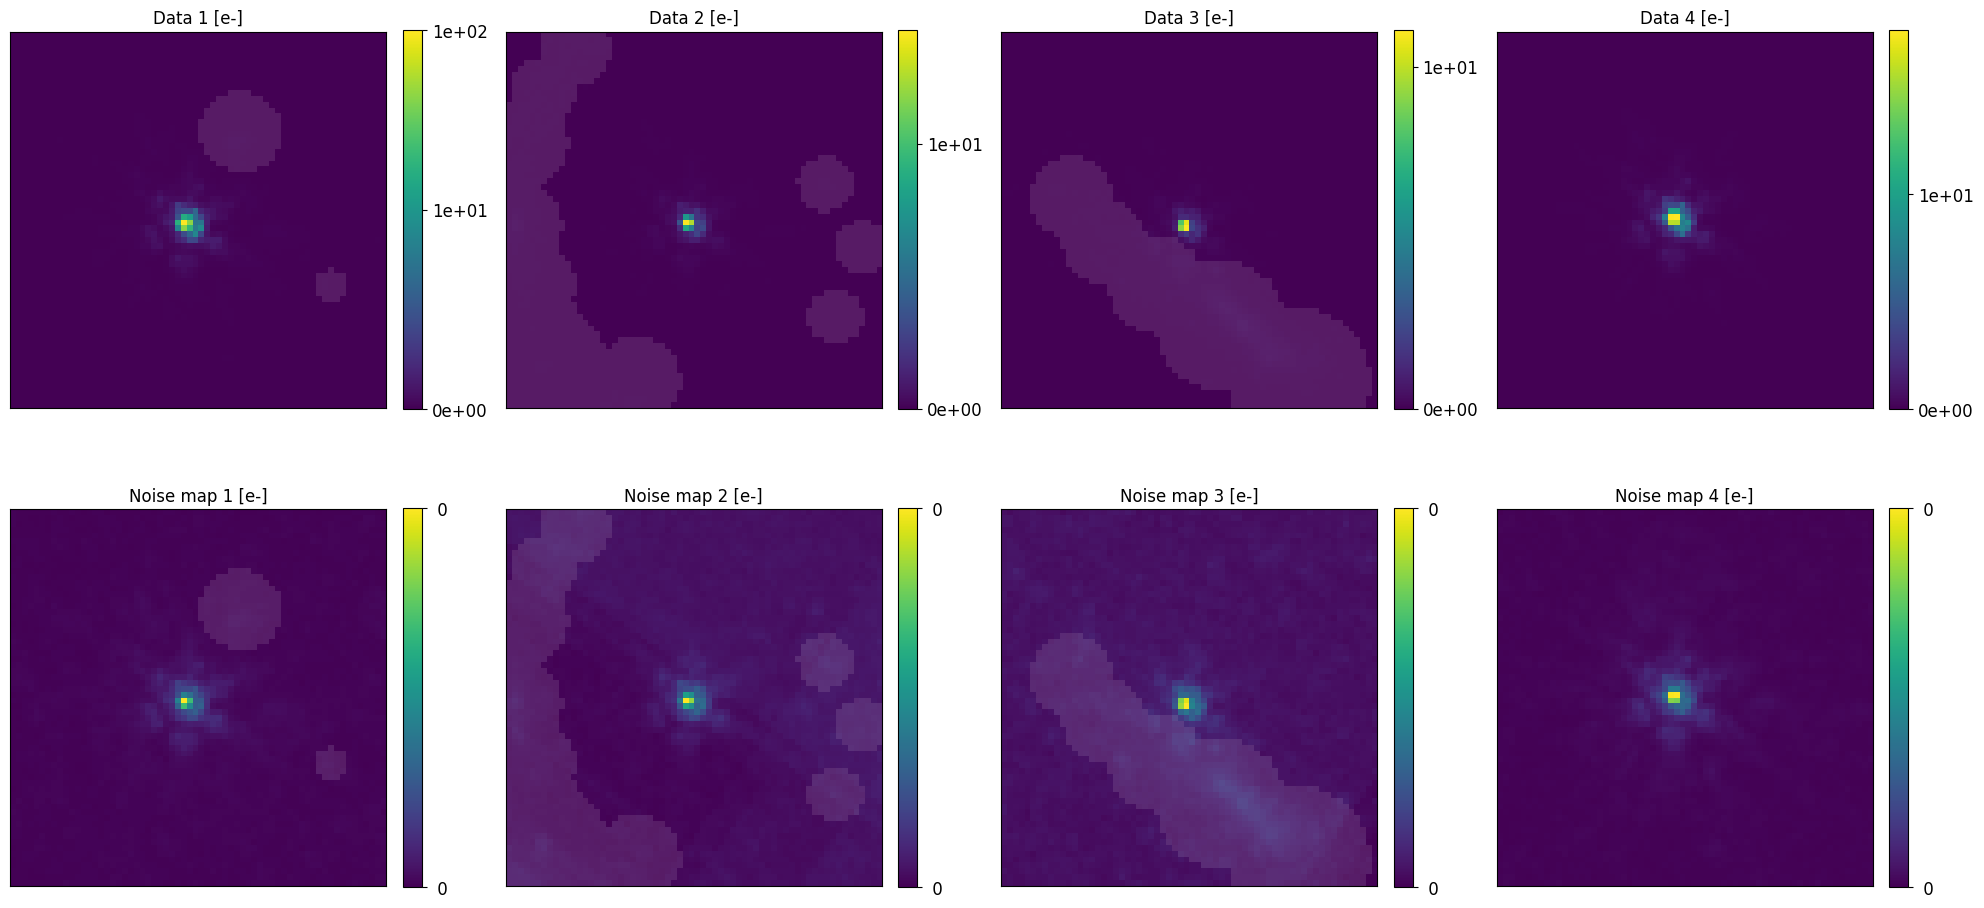

In [5]:
fig=pltf.display_data(data, sigma_2=sigma_2, masks=masks, units='e-')

In [6]:
# Build the PSF model class
model = PSF(image_size=image_size, number_of_sources=N, 
            upsampling_factor=subsampling_factor, 
            convolution_method=convolution_method,
            include_moffat = include_moffat,
            elliptical_moffat = elliptical)

# Parameter initialization. 
kwargs_init, kwargs_fixed, kwargs_up, kwargs_down = model.smart_guess(data, fixed_background=True)
#reset the position to 0 as the JWST is too complex for barycentric estimates of the center position
kwargs_init['kwargs_gaussian']['x0'] = np.array([0. for i in range(N)])
kwargs_init['kwargs_gaussian']['y0'] = np.array([0. for i in range(N)])

print('Initial Guess :', kwargs_init) 

parameters = ParametersPSF(kwargs_init, kwargs_fixed, kwargs_up=kwargs_up, kwargs_down=kwargs_down)

Initial Guess : {'kwargs_moffat': {'fwhm': 3.0, 'beta': 2.0, 'C': 21.058484436377213}, 'kwargs_gaussian': {'a': Array([33.18653225, 11.88569183,  7.27848314, 31.88323368], dtype=float64), 'x0': array([0., 0., 0., 0.]), 'y0': array([0., 0., 0., 0.])}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}


# Analytical Fit 
We first fit an analytical model (a Moffat function) to speed-up the convergence. We will refine the fit later with a regularized grid of pixels.

In [7]:
# Moffat fitting and amplitude tunning 
loss = Loss(data, model, parameters, sigma_2, N, regularization_terms='l1_starlet', 
            regularization_strength_scales=0, regularization_strength_hf=0, masks = masks) 
optim = Optimizer(loss, parameters, method=optim_method)

optimiser_options = {'maxiter':1000, 
                     'restart_from_init':True}

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_options)

/Users/martin/Desktop/modules/starred/starred/optim/optimization.py:78: UserWarning: You are using an unconstrained optimiser. Bounds are ignored.
  warnings.warn('You are using an unconstrained optimiser. Bounds are ignored.')


Moffat fit : {'kwargs_moffat': {'fwhm': Array([1.70603002], dtype=float64), 'beta': Array([2.03597944], dtype=float64), 'C': Array([21.05848444], dtype=float64)}, 'kwargs_gaussian': {'a': Array([33.12547731, 11.87387518,  7.26322072, 31.83367757], dtype=float64), 'x0': Array([-1.05916905, -0.19688794, -0.06221411, -1.17944354], dtype=float64), 'y0': Array([-0.47715626, -0.1450099 , -0.10770065, -0.06652793], dtype=float64)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)}}


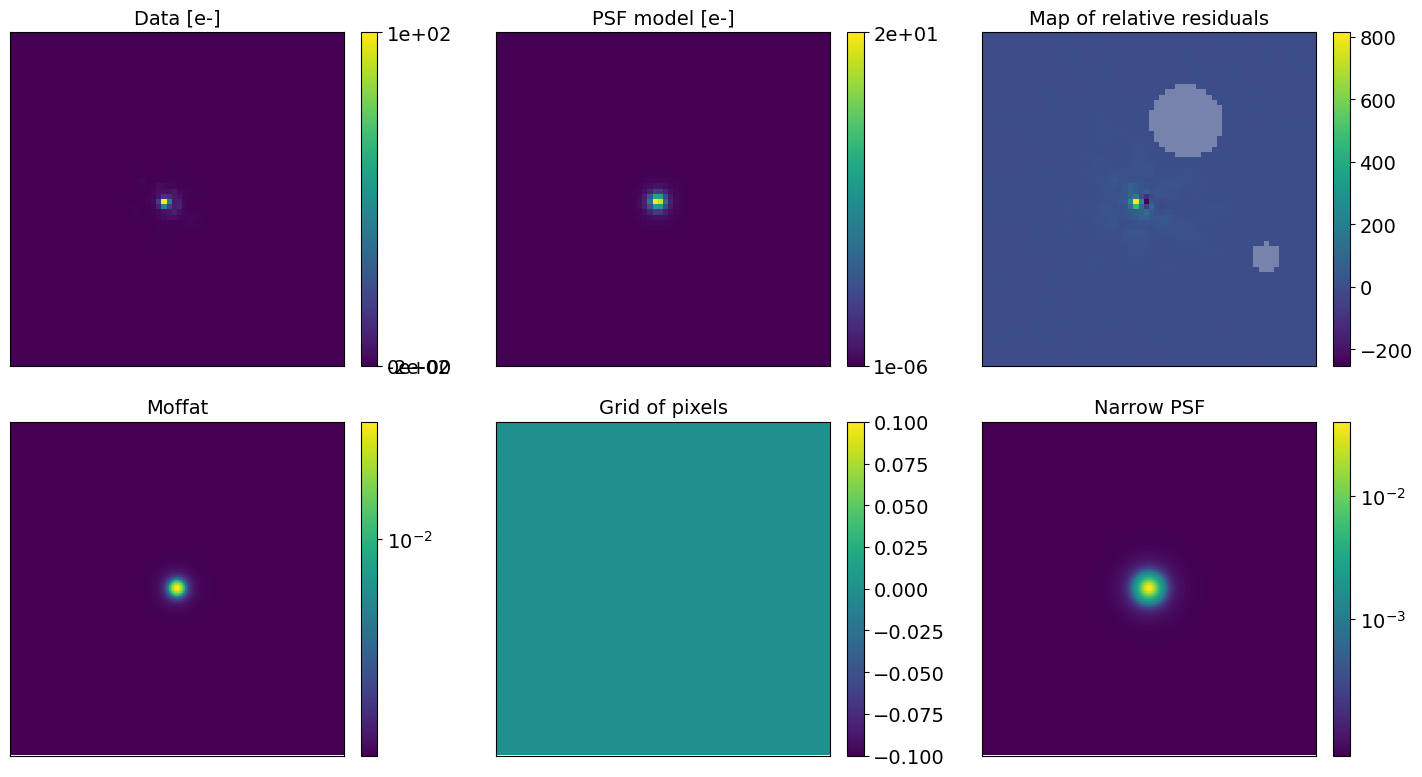

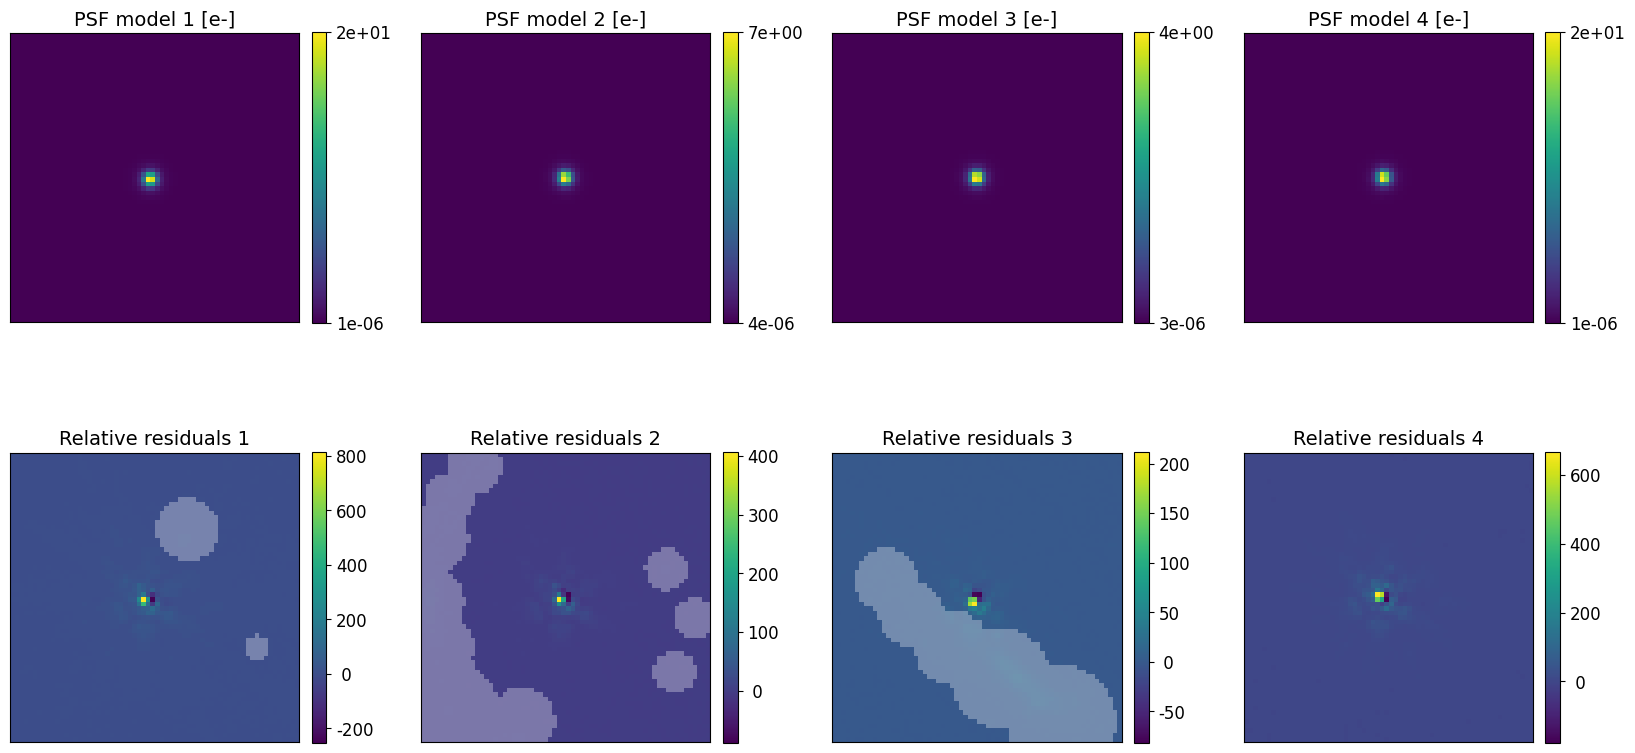

In [8]:
# Printing partial results
kwargs_partial = parameters.args2kwargs(best_fit)
print('Moffat fit :',kwargs_partial) 

fig2 = pltf.single_PSF_plot(model, data, sigma_2, kwargs_partial,masks=masks, n_psf=0, units='e-')
fig3 = pltf.multiple_PSF_plot(model, data, sigma_2, kwargs_partial,masks=masks, units='e-')

## Noise propagation 
We use this rough model to compute the Poisson noise progation in starlet space. This allows us to adjust the weight, W, and interpret `lambda_hf` and `lambda_scale` in unit of the standard deviation of the noise. 

In [9]:
# compute noise level in starlet space, also propagate poisson noise
W = propagate_noise(model, np.sqrt(sigma_2), kwargs_partial, masks=masks, wavelet_type_list=['starlet'], method='MC', num_samples=MC_realisation,
             seed=1, likelihood_type='chi2', verbose=False, upsampling_factor=subsampling_factor, scaling_noise_ref = None)[0]


/Users/martin/Desktop/modules/starred/starred/utils/noise_utils.py:52: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)


# Run the full model
Now that our noise level is calibrated, we will also optimise the regularized grid. This time we need an optimiser that can handle a large number of free parameters : `adabelief`

In [10]:
# Release backgound, fix the moffat amplitude
kwargs_moffat_fixed = {'C':kwargs_partial['kwargs_moffat']['C']}

kwargs_fixed = {
    'kwargs_moffat': kwargs_moffat_fixed,
    'kwargs_gaussian': {},
    'kwargs_background': {},
}

parameters = ParametersPSF(kwargs_partial, kwargs_fixed, kwargs_up, kwargs_down)

loss = Loss(data, model, parameters, sigma_2, N, regularization_terms='l1_starlet',
            regularization_strength_scales=lambda_scales, regularization_strength_hf=lambda_hf,
            regularization_strength_positivity=lambda_positivity, W=W, regularize_full_psf=regularize_full_psf, masks=masks)


optim = Optimizer(loss, parameters, method='adabelief')

kwargs_optim = {
                'max_iterations': 1500, 'min_iterations': None,
                'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
                'restart_from_init': False, 'stop_at_loss_increase': False,
                'progress_bar': True, 'return_param_history': True
            }
best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**kwargs_optim)

optax.adabelief: 100%|██████████| 1500/1500 [00:23<00:00, 64.51it/s]


{'kwargs_moffat': {'fwhm': Array([1.83619358], dtype=float64), 'beta': Array([1.59197415], dtype=float64), 'C': Array([21.05848444], dtype=float64)}, 'kwargs_gaussian': {'a': Array([62.12037363, 20.1030426 , 11.69138395, 61.47494728], dtype=float64), 'x0': Array([-2.21961881, -1.07395323, -0.73438246, -1.91282012], dtype=float64), 'y0': Array([-0.67978651, -0.53846808, -1.06734637,  0.18262228], dtype=float64)}, 'kwargs_background': {'background': Array([-1.10109444e-03,  1.52540153e-03,  4.35534693e-06, ...,
        1.39459456e-03,  2.03336851e-03,  1.29391440e-03], dtype=float64)}}


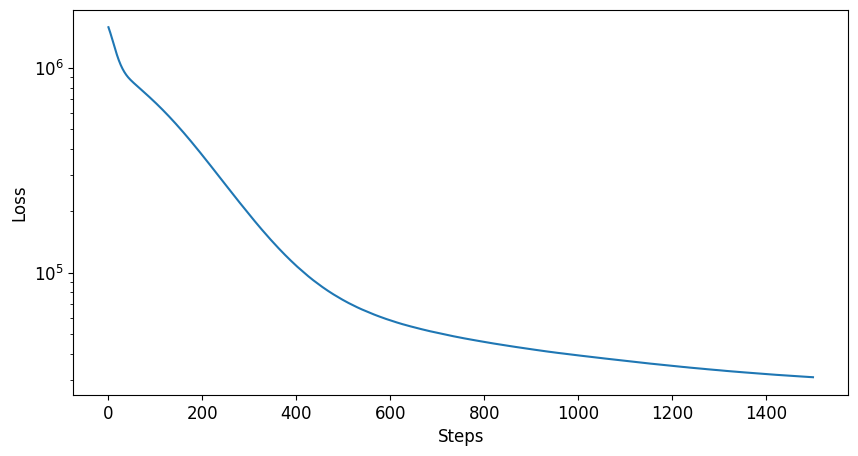

In [11]:
fig_loss = pltf.plot_loss(extra_fields['loss_history'])

kwargs_final = parameters.args2kwargs(best_fit)
print(kwargs_final)

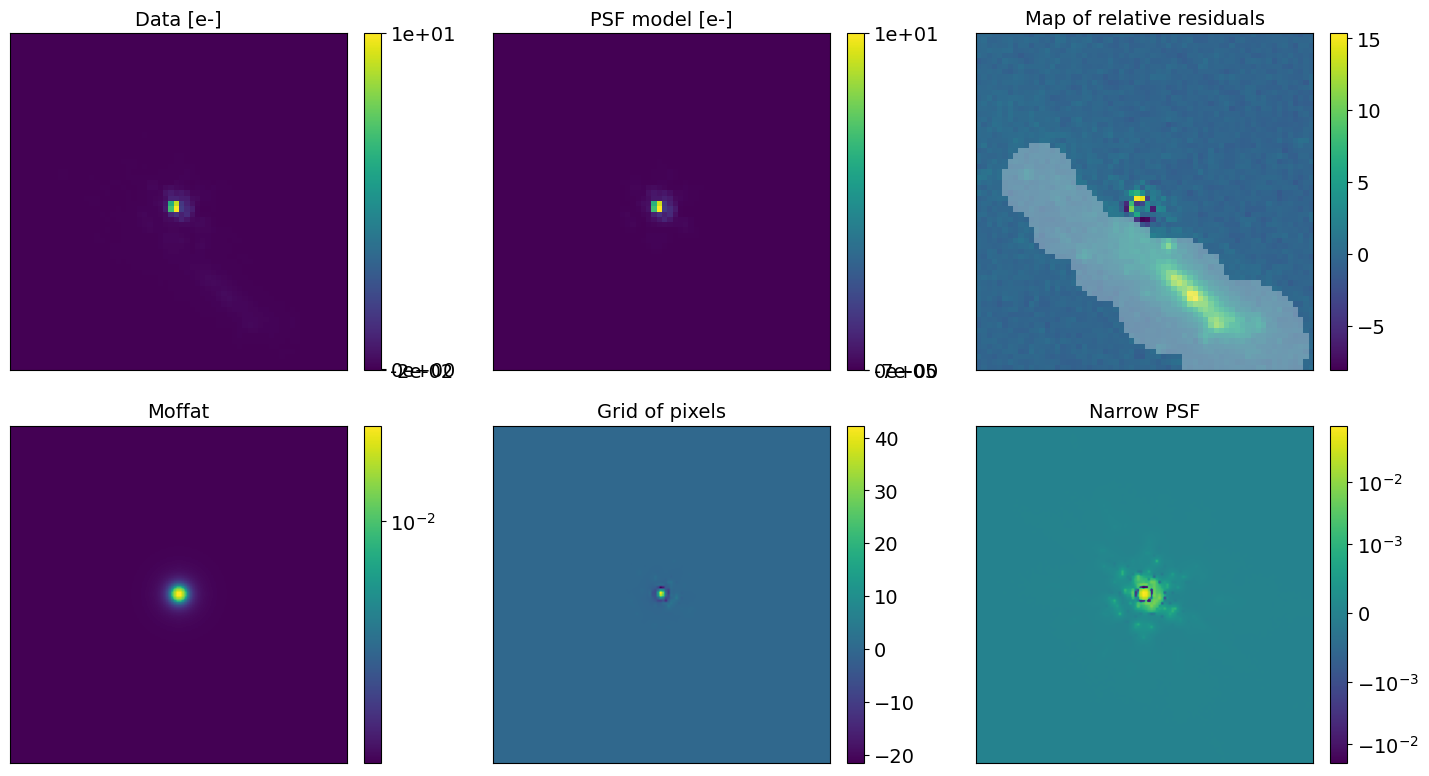

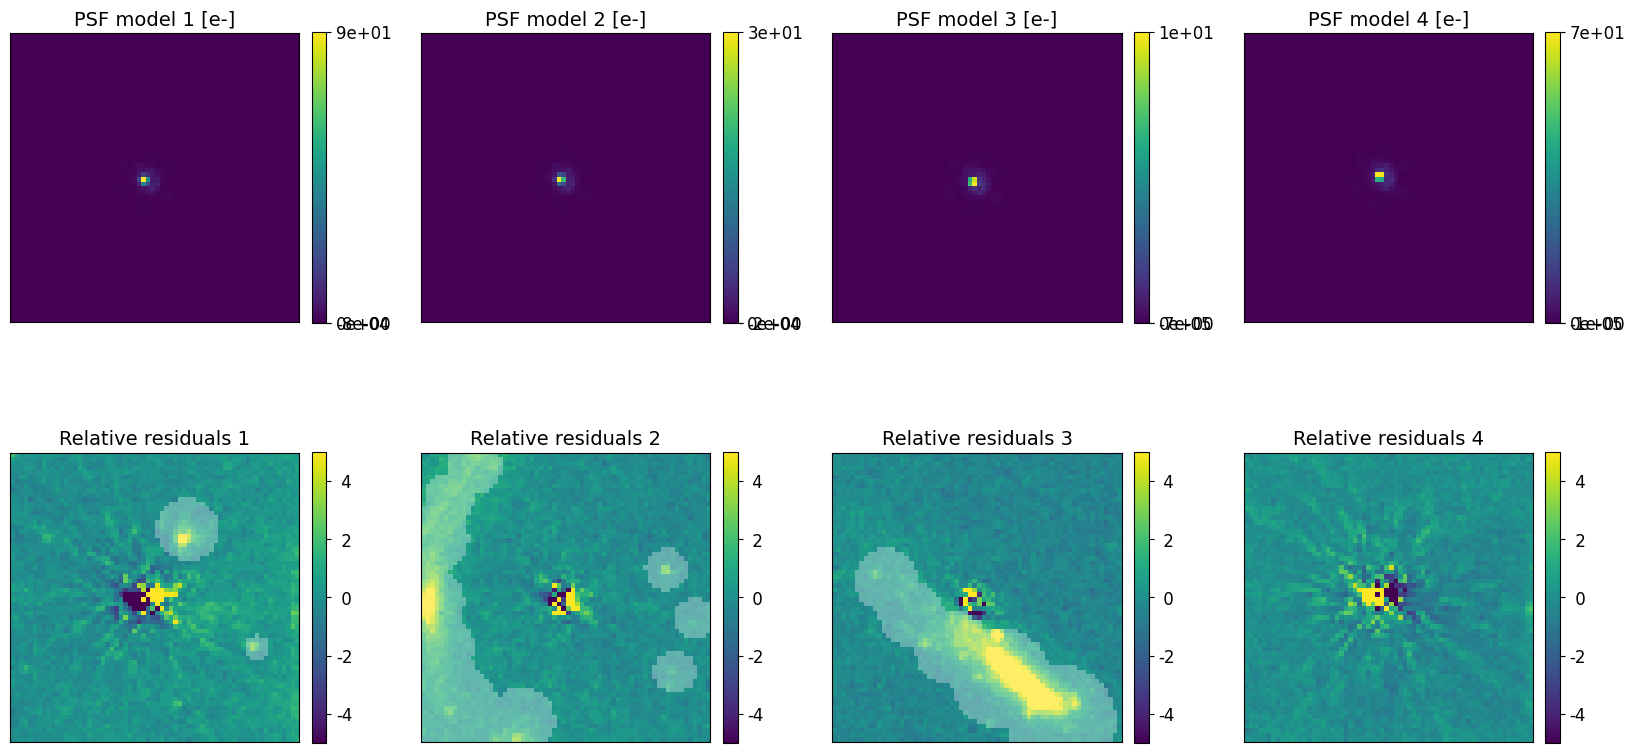

In [12]:
fig2 = pltf.single_PSF_plot(model, data, sigma_2, kwargs_final, masks=masks, n_psf=2, units='e-')
fig3 = pltf.multiple_PSF_plot(model, data, sigma_2, kwargs_final, masks=masks, units='e-', vmin=-5, vmax=5)

This is a rather good fit but the data are not modelled down to the noise level in the central region. However, the residuals are uncorrelated, so residual errors might be due to i) unperfect Poisson noise estimation, ii) PSF distortion across the field of view since the selected stars are close from each other but not exactly at the same positions and iii) difference in SED within the wide photometric band. 

/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_1589/3431535332.py:4: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.nan_to_num(np.log10(full_psf), nan=-10), origin='lower', vmin=-5.8, vmax=-2)


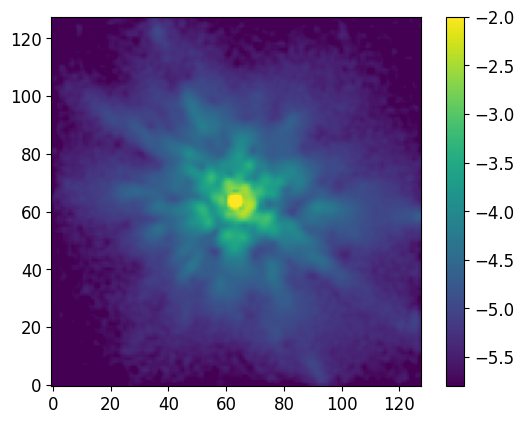

In [13]:
full_psf = model.get_full_psf(**kwargs_final)

fig5 = plt.figure()
plt.imshow(np.nan_to_num(np.log10(full_psf), nan=-10), origin='lower', vmin=-5.8, vmax=-2)
plt.colorbar()

## Save the final model

In [14]:
#model.export(outpath, kwargs_final, data, sigma_2, format='fits')

# Make some plots

Mean noise level in each starlet scale: 
Scale 0 : 18.31370525531034
Scale 1 : 14.317221927835092
Scale 2 : 8.222338349992484
Scale 3 : 4.215040941530591
Scale 4 : 2.0591897336465155
Scale 5 : 0.9697635054714767
Scale 6 : 0.426046502941814


/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_1589/1690884523.py:18: RuntimeWarning: invalid value encountered in log10
  axs[-1].imshow(np.nan_to_num(np.log10(full_psf), nan=-10), origin='lower', cmap=cmap, vmin=-6, vmax=-2)


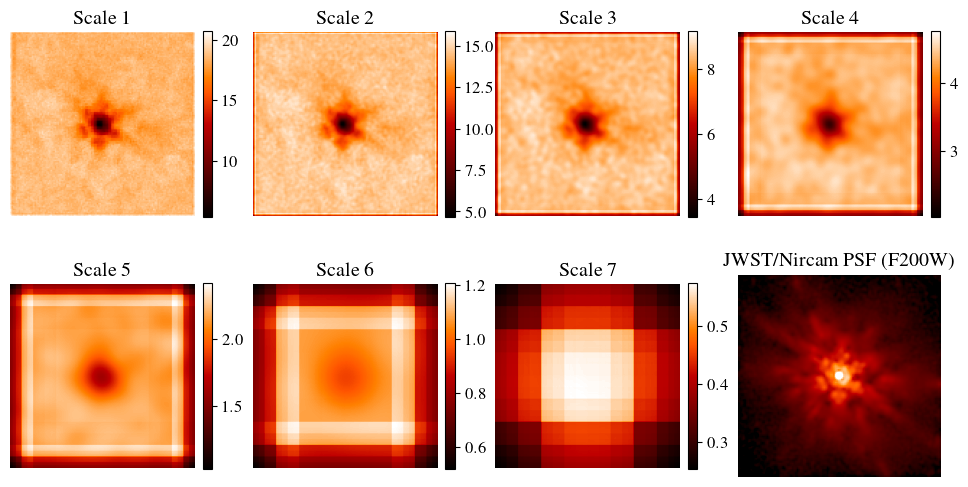

In [15]:
#This is a representation of your noise maps (background + Poisson) in the different starlet scales
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

cmap='gist_heat'
fraction = 0.046
pad = 0.04
gix, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = np.ravel(axs)
print('Mean noise level in each starlet scale: ')
for i, l in enumerate(W[:-1]):
    gix.colorbar(axs[i].imshow(l, origin='lower', cmap=cmap), ax=axs[i], fraction=fraction, pad=pad)
    axs[i].axis("off")
    axs[i].set_title('Scale %i'%(i+1))
    print('Scale %i :'%i, np.mean(l))

axs[-1].imshow(np.nan_to_num(np.log10(full_psf), nan=-10), origin='lower', cmap=cmap, vmin=-6, vmax=-2)
axs[-1].set_title('JWST/Nircam PSF (F200W)')
axs[-1].axis("off")

plt.show()
gix.savefig(os.path.join(outpath, 'W_matrix.pdf'), dpi=200)

# You can save the weight matrix W to avoid recomputation
#np.save('./output/7_output_JWST_PSF/W_MC_chi2.npy', W)